In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import hist
import vector
import os
import subprocess
import gc
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
print("uproot version", uproot.__version__)
print("awkward version", ak.__version__)
print("numpy version", np.__version__)
print("matplotlib version", matplotlib.__version__)
print("hist version", hist.__version__)
print("vector version", vector.__version__)
#print("os version", os.__version__)
#print("subprocess version", subprocess.__version__)
#print("gc version", gc.__version__)
print("pandas version", pd.__version__)
#print("scipy.optimize version", scipy.optimize.__version__)
#print("scipy.integrate version", scipy.integrate.__version__)

uproot version 5.0.12
awkward version 2.4.3
numpy version 1.25.2
matplotlib version 3.8.0
hist version 2.7.2
vector version 1.1.1
pandas version 1.5.3


In [2]:
X = [1.5174999999999998, 1.5525, 1.5875, 1.6225, 1.6574999999999998, 1.6925, 1.7275, 1.7625000000000002, 
     1.7975, 1.8325, 1.8675000000000002, 1.9025000000000003, 1.9375, 1.9725, 2.0075, 2.0425, 2.0775, 2.1125, 
     2.1475, 2.1825, 2.2175000000000002, 2.2525, 2.2875, 2.3225, 2.3575, 2.3925, 2.4275, 2.4625, 2.4975, 
     2.5324999999999998, 2.5675, 2.6025, 2.6375, 2.6725000000000003, 2.7075, 2.7424999999999997, 2.7775, 
     2.8125, 2.8475, 2.8825000000000003, 2.9175000000000004, 2.9524999999999997, 2.9875, 3.0225, 3.0575, 
     3.0925, 3.1275, 3.1625, 3.1975, 3.2325, 3.2675, 3.3025, 3.3375, 3.3725000000000005, 3.4074999999999998, 
     3.4425000000000003, 3.4775, 3.5125, 3.5475, 3.5824999999999996, 3.6174999999999997, 3.6525000000000003, 
     3.6875, 3.7224999999999997, 3.7575000000000003, 3.7925000000000004, 3.8275, 3.8625, 3.8975, 
     3.9324999999999997, 3.9675, 4.0024999999999995, 4.0375, 4.0725, 4.1075, 4.1425, 4.1775, 4.2125, 
     4.2475000000000005, 4.2825, 4.3175, 4.352499999999999, 4.3875, 4.422499999999999, 4.4575, 
     4.492500000000001, 4.5275, 4.5625, 4.5975, 4.632499999999999, 4.6675, 4.702500000000001, 4.7375, 
     4.772500000000001, 4.8075, 4.842499999999999, 4.8775, 4.9125, 4.9475, 4.9825]

# CMUL + pT
Y = [65395.0, 64049.0, 61278.0, 59957.0, 57952.0, 55134.0, 53694.0, 51514.0, 49552.0, 47938.0, 46195.0, 44215.0, 42135.0, 40748.0, 
               38787.0, 37016.0, 35089.0, 33769.0, 32589.0, 31205.0, 29683.0, 28538.0, 27035.0, 25838.0, 24917.0, 23880.0, 22941.0, 21940.0, 
               21160.0, 20369.0, 19407.0, 18797.0, 18185.0, 17563.0, 17024.0, 16816.0, 16630.0, 16663.0, 17058.0, 17736.0, 20045.0, 23039.0, 
               28648.0, 37345.0, 46901.0, 52737.0, 48976.0, 37220.0, 23990.0, 15203.0, 10782.0, 8746.0, 7829.0, 7117.0, 6605.0, 6279.0, 6109.0,
               5939.0, 5757.0, 5705.0, 5597.0, 5683.0, 5411.0, 5254.0, 4994.0, 4462.0, 4154.0, 3849.0, 3749.0, 3682.0, 3496.0, 3390.0, 3244.0, 
               3219.0, 3038.0, 2948.0, 2991.0, 2701.0, 2738.0, 2603.0, 2530.0, 2520.0, 2435.0, 2299.0, 2301.0, 2187.0, 2106.0, 2093.0, 1929.0, 
               1938.0, 1861.0, 1918.0, 1765.0, 1803.0, 1718.0, 1664.0, 1687.0, 1562.0, 1614.0, 1486.0]

vMass_OS = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name='$m_{\mu \mu}$', label = 'X'))
vMass_OS.fill(X, weight = Y)

Hist(Regular(100, 1.5, 5, name='$m_{\\mu \\mu}$', label='X'), storage=Double()) # Sum: 1891982.0

In [3]:
def funcVec(x, N, mu, sig, alphaL, nL, alphaR, nR):
    AL = ( nL / np.absolute( alphaL ) )**nL * np.exp( -1 * np.absolute( alphaL )**2 / 2 )
    AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
    BL = nL / np.absolute( alphaL ) - np.absolute( alphaL )
    BR = nR / np.absolute( alphaR ) - np.absolute( alphaR )

    return np.piecewise(x, 
                        [( x - mu )/sig < -1 * alphaL, (( x - mu )/sig >= -1 * alphaL) & (( x - mu )/sig <= alphaR).any() , ( x - mu )/sig > alphaR],
                        [lambda x: N * AL * (BL - (( x - mu )/sig))**(-nL), lambda x: N * np.exp(-1 * (( x - mu )/sig)**2 / 2), lambda x: N * AR * (BR + ( x - mu )/sig)**(-nR)])

def VWG(x, N, mu, alpha, beta):
    sigma = alpha + beta*((x-mu)/mu)
    return N * np.exp(-(x - mu)**2 / (2*sigma**2))

def PR(x, N, a1, b1, b2):
    return N * (1 + a1*x) / (b1*x + b2*x)

def DE(x, N, alpha, beta1, beta2):
    return N * (np.exp(beta1*x) + alpha * np.exp(beta2*x))

def fitFunc(x,
            N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1,
            N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2,
            Nbg, a1, a2, a3):
    return funcVec(x, N1, mu1, sig1, alphaL1, nL1, alphaR1, nR1) + funcVec(x, N2, mu2, sig2, alphaL2, nL2, alphaR2, nR2) + DE(x, Nbg, a1, a2, a3)

In [4]:
x_data = np.array(X)
y_data = np.array(vMass_OS)
y_error = np.array(np.sqrt(vMass_OS))

condition = (x_data > 2.0)
#condition = True
x_filtered = np.ravel(x_data[condition])
y_filtered = np.ravel(y_data[condition])
y_error_filtered = np.ravel(y_error[condition])

x_data = x_filtered
y_data = y_filtered
y_error = y_error_filtered

In [5]:
p0 = np.array([4.55480661e+04, 3.09865210e+00, 6.61685782e-02, 8.82346075e-01,
               3.02220911e+00, 2.02907631e+00, 2.80816984e+00, 1.00000000e+03,
               3.69645336e+00, 5.19889713e-02, 1.05368114e+00, 3.30817422e+00,
               2.65615253e+00, 2.93595354e+00, 2.27919897e+04, 4.53001147e+01,
               -5.76132695e-01, -1.64742979e+00])

In [6]:
popt, pcov, nfev, fvec, fjac = curve_fit(fitFunc, xdata = x_data, ydata = y_data, sigma = y_error, p0 = p0,  method = 'trf', full_output = True)

print("popt: \n", popt) 
print("pcov: \n", pcov)
print("residual: \n", nfev)

popt: 
 [ 4.34346001e+04  3.09447591e+00  7.29521704e-02  9.96696169e-01
  3.04366213e+00  1.82082157e+00  2.55669142e+01  7.14807206e+02
  3.68534012e+00  6.54321063e-02  1.03781632e+00  1.42893686e+02
  1.09277059e+01  1.63297285e+02  2.22753488e+04  3.34947479e+01
 -5.98220438e-01 -1.56101540e+00]
pcov: 
 [[ 9.62681763e+04  1.97936871e-02 -9.63174097e-02  8.80274783e-01
  -5.13447890e+01 -1.33317795e+01  1.64403491e+03  3.92509356e+03
  -1.10908455e-01  4.42290578e-01  1.90291184e+01 -1.58390904e+06
   2.78138793e-09 -9.73571792e-09  8.11754505e+05 -8.62367447e+02
  -5.69255297e+00 -7.77620893e+00]
 [ 1.97936871e-02  3.27571213e-07 -1.75906561e-07 -9.79550807e-06
   1.02536528e-04  4.12375098e-06 -1.78034208e-03 -2.29023288e-03
   1.39856376e-07 -2.48306050e-07 -3.70310065e-05  1.86932272e+00
  -2.89714741e-15  1.15644627e-14 -1.24193256e+00  1.49782386e-03
   9.31779687e-06  9.30746897e-06]
 [-9.63174097e-02 -1.75906561e-07  4.74009542e-07  1.32039774e-05
  -1.56420695e-04  5.79676

/tmp/ipykernel_5938/3209874668.py:3: RuntimeWarning: overflow encountered in scalar power
  AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
/tmp/ipykernel_5938/3209874668.py:9: RuntimeWarning: invalid value encountered in multiply
  [lambda x: N * AL * (BL - (( x - mu )/sig))**(-nL), lambda x: N * np.exp(-1 * (( x - mu )/sig)**2 / 2), lambda x: N * AR * (BR + ( x - mu )/sig)**(-nR)])
/tmp/ipykernel_5938/3209874668.py:2: RuntimeWarning: overflow encountered in scalar power
  AL = ( nL / np.absolute( alphaL ) )**nL * np.exp( -1 * np.absolute( alphaL )**2 / 2 )
/tmp/ipykernel_5938/3209874668.py:9: RuntimeWarning: overflow encountered in scalar multiply
  [lambda x: N * AL * (BL - (( x - mu )/sig))**(-nL), lambda x: N * np.exp(-1 * (( x - mu )/sig)**2 / 2), lambda x: N * AR * (BR + ( x - mu )/sig)**(-nR)])


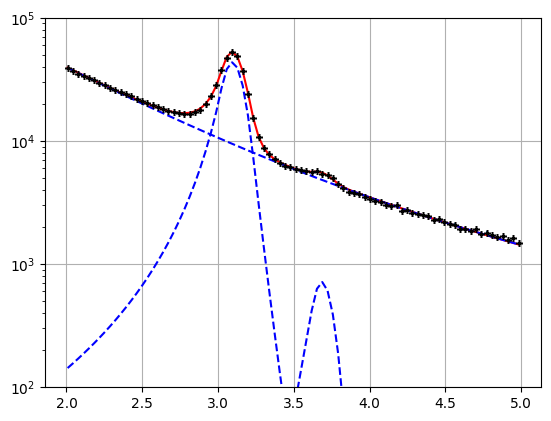

In [7]:
x_data_fit = np.linspace(min(x_data), max(x_data), len(x_data))
plt.errorbar(x_data, y_data, y_error, marker='+', mfc='black', mec='black', ms=2, mew=5, ls='')
plt.plot(x_data_fit, fitFunc(x_data_fit, *popt), '-r')
plt.plot(x_data_fit, funcVec(x_data_fit, *popt[:7]), '--b')
plt.plot(x_data_fit, funcVec(x_data_fit, *popt[7:14]), '--b')
plt.plot(x_data_fit, DE(x_data_fit, *popt[14:18]), '--b')
plt.yscale('log')
plt.ylim(100, 100000)
plt.grid(True)

In [8]:
print(quad(fitFunc, 2.7, 3.3, args = (*popt, )))

(15629.641825209714, 3.9773496383864026e-05)


In [12]:
print(quad(funcVec, 0, np.inf, args = (*popt[:7], )))

(9617.890917678671, 3.574336594980049e-05)


In [13]:
signal = quad(funcVec, 0, np.inf, args = (*popt[:7], ))[0]
bruit = quad(funcVec, 0, np.inf, args = (*popt[7:14], ))[0] + quad(DE, 0, np.inf, args = (*popt[14:18], ))[0]
print("Signal :", signal)
print("Bruit :", bruit)

Signal : 9617.890917678671
Bruit : 515324.9362062188


In [14]:
print("RSB :", signal / np.sqrt(signal + bruit))

RSB : 13.274673382003627
